In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from neicio.readstation import readStation
from neicio.shake import ShakeGrid
from neicio.gmt import GMTGrid
from openquake.hazardlib.correlation import JB2009CorrelationModel
from openquake.hazardlib.correlation import BaseCorrelationModel
from openquake.hazardlib.geo.geodetic import geodetic_distance
from openquake.hazardlib.imt import from_string
from openquake.hazardlib.imt import PGA as IMT
import time
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import sys
sys.path.append('/Users/sverros/Documents/Modules')
from Correlation.setup import initialize
from Correlation.loop import main
from Correlation.realizations import realizations
from Correlation.testing_code import run


# Variable of interest                                                                                                                                                                                                        
voi = 'PGA'
# Specify the radius of interest                                                                                                                                                                                              
r = 10
# Specify number of realizations
num_realizations = 4

# Get shakemap for desired variable, PGA, uncertainty grid and stationdata                                                                                                                                                    
# Selected Stations: Units in pctg                                                                                                                                                                                            
shakemap = ShakeGrid('/Users/sverros/Documents/Reduced_output/grid.xml', variable = '%s' % voi)

# Uncertainty Data: Units in ln(pctg)                                                                                                                                                                                         
uncertainty = ShakeGrid('/Users/sverros/Documents/Reduced_output/uncertainty.xml', variable= 'STD%s' % voi)

# Station Data: Units in pctg                                                                                                                                                                                                 
stationlist = '/Users/sverros/Documents/Reduced_output/stationlist.xml'
stationdata = readStation(stationlist)

# Used for plotting                                                                                                                                                                                                           
topofile = '/Users/sverros/Documents/etopo1_bed_g_f4.grd'

# Sets up grid spacing, site collections, and other data values
# optional parameters: dm, dn, the grid discritization defaulting to 1
variables = initialize(shakemap, uncertainty, stationdata)

# Calculate the random array, stored for testing
rand = np.random.randn(variables['N']*variables['M'])

# Main program for computing spatial correlation
# Output is a dictionary with the following keys
#     cor- grid of spatially correlated epsilon                                                                                                                                
#     data- grid of ShakeMap data                                                                                                                                              
#     data_new- data with added spatial correlation                                                                                                                            
#     grid_arr- array for storing grid indices for multiple realizations                                                                                                       
#     mu_arr- array for storing Sig21.T*Sig11inv for multiple realizations                                                                                                     
#     sigma_arr- array for storing sigma for multiple realizations  
out = main(variables, r, voi, rand)

# Calculate multiple realizations
ACCUM_ARRAY = realizations(num_realizations, variables['N'], variables['M'], out['grid_arr'], 
                           out['mu_arr'], out['sigma_arr'], variables['uncertaintydata'], out['data'])

Calling initialize
	Initialization Time: 0.382719993591
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 13.7361960411
Pre loop Time 0.00151705741882
Inner loop time 13.2411823273
Outer loop time 0.247411966324
Simulating realizations
Done with 1 of 4 iterations.
Done with 2 of 4 iterations.
Done with 3 of 4 iterations.
Done with 4 of 4 iterations.


/Users/sverros/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


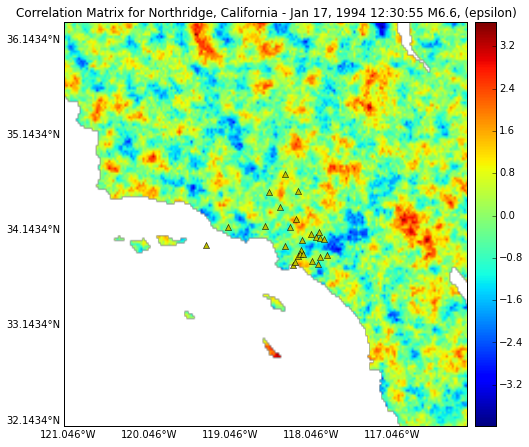

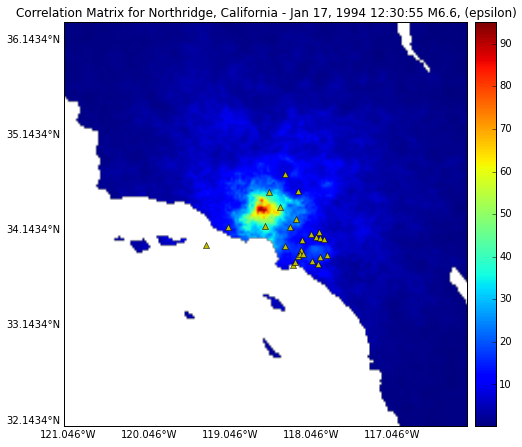

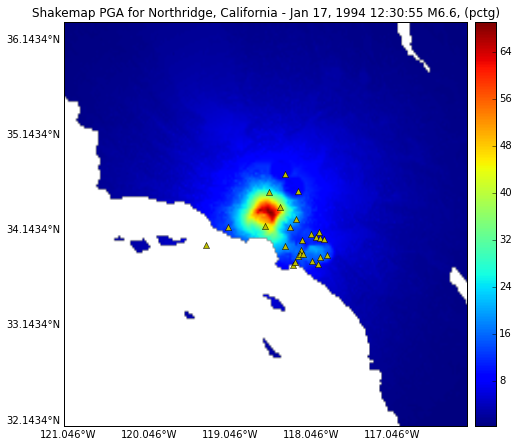

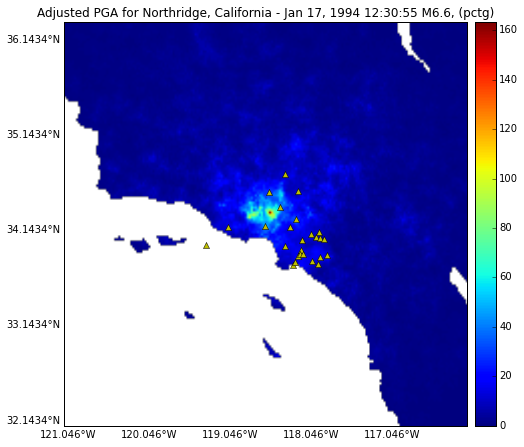

In [2]:
maxdata = np.amax(out['data_new'])
attributes = shakemap.getAttributes()
station_lons = stationdata['lon']
station_lats = stationdata['lat']

xmin,xmax,ymin,ymax = shakemap.getRange()
geodict = shakemap.getGeoDict()
xmin -= (geodict['xdim']*2)
xmax += (geodict['xdim']*2)
ymin -= (geodict['ydim']*2)
ymax += (geodict['ydim']*2)
topo = GMTGrid(topofile,bounds=(xmin,xmax,ymin,ymax))
topo.interpolateToGrid(geodict)
clear_color = [0,0,0,0.0]

CORdata = np.flipud(out['cor'].copy())
ACCUMdata = np.flipud(ACCUM_ARRAY.copy())
DATAdata = np.flipud(variables['data'].copy())
DATA_NEWdata = np.flipud(out['data_new'].copy())
topodata = np.flipud(topo.griddata.copy())
iwater = np.where(topodata < 0)

CORdata[iwater] = 0.0101
ACCUMdata[iwater] = 0.0101
DATAdata[iwater] = 0.0101
DATA_NEWdata[iwater] = 0.0101

palette = cm.jet
COR_masked = np.ma.masked_equal(CORdata, 0.0101)
ACCUM_masked = np.ma.masked_equal(ACCUMdata, 0.0101)
DATA_masked = np.ma.masked_equal(DATAdata, 0.0101)
DATA_NEW_masked = np.ma.masked_equal(DATA_NEWdata, 0.0101)

clat = ymin + (ymax-ymin)/2.0
clon = xmin + (xmax-xmin)/2.0
m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='i',area_thresh=1000.,projection='lcc',\
            lat_1=clat,lon_0=clon)

fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(COR_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Correlation Matrix for %s - %s M%.1f, (epsilon)' % (locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)

fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(ACCUM_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Correlation Matrix for %s - %s M%.1f, (epsilon)' % (locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)


fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(DATA_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
#plt.clim(0,maxdata)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Shakemap %s for %s - %s M%.1f, (pctg)' % (voi,locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)


fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(DATA_NEW_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
#plt.clim(0,maxdata)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Adjusted %s for %s - %s M%.1f, (pctg)' % (voi,locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)

In [2]:
rand = np.random.randn(variables['N']*variables['M'])

R = [5, 10, 15, 20, 25, 30, 35]

data_NEW = np.zeros([variables['M']*variables['N'], np.size(R)])

for k in range(0,np.size(R)):
    out = run(R[k], rand)
    data_NEW[:,k] = np.reshape(out, [variables['N']*variables['M']])



Calling initialize
	Initialization Time: 0.354723930359
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 9.29288291931
Pre loop Time 0.000951051712036
Inner loop time 8.99284005165
Outer loop time 0.060483455658
Calling initialize
	Initialization Time: 0.343170881271
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 13.3826680183
Pre loop Time 0.000899791717529
Inner loop time 12.8869364262
Outer loop time 0.249104976654
Calling initialize
	Initialization Time: 0.39369893074
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 28.2944200039
Pre loop Time 0.000845909118652
Inner loop time 27.4354777336
Outer loop time 0.601193

In [4]:
for k in range(0,np.size(R)-1):
    print 'mean difference', np.mean(abs(data_NEW[:,k] - data_NEW[:,k+1]))
    print 't-value, p-value', scipy.stats.ttest_ind(data_NEW[:,k], data_NEW[:,k+1])
    
for k in range(0,np.size(R)-1):
    print 'max difference', max(data_NEW[:,k] - data_NEW[:,np.size(R)-1])
    print 'mean difference', np.mean(abs(data_NEW[:,k] - data_NEW[:,np.size(R)-1]))
    print 't-value, p-value', scipy.stats.ttest_ind(data_NEW[:,k], data_NEW[:,np.size(R)-1])

mean difference 0.444277115016
t-value, p-value (-1.7380517434222611, 0.08220630968268651)
mean difference 0.115135663963
t-value, p-value (-0.28500267713818322, 0.77564297536588267)
mean difference 0.0593138615219
t-value, p-value (0.0047830888257866791, 0.9961836761224967)
mean difference 0.0412738063395
t-value, p-value (0.075749731133594178, 0.93961843697488368)
mean difference 0.0379138335465
t-value, p-value (-0.09117088732816063, 0.92735708079204471)
mean difference 0.0308340740886
t-value, p-value (0.0066010081297727041, 0.99473321550853555)
max difference 8.17945463222
mean difference 0.529727186234
t-value, p-value (-2.043592663735744, 0.040997723031860424)
max difference 14.7743144654
mean difference 0.169594943359
t-value, p-value (-0.29087729030343418, 0.7711460744092723)
max difference 15.4705143737
mean difference 0.0904422190296
t-value, p-value (-0.0037324469517538558, 0.99702195627499735)
max difference 4.85119353687
mean difference 0.0548191021259
t-value, p-value (-

In [37]:
np.shape(data_NEW)

(33366, 5)